In [ ]:
!pip install basemap

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
import requests
import math
import urllib
import seaborn as sns
import json
from sklearn.feature_extraction import _stop_words
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS
nltk.download('omw-1.4')
import shutil
from mpl_toolkits.basemap import Basemap
import zipfile
from zipfile import ZipFile
import os

#from fa2 import ForceAtlas2

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
url = 'https://raw.githubusercontent.com/d2ski/football-transfers-data/main/dataset/transfers.csv'
df = pd.read_csv(url)
df=df[df['league']=='GB1'] # If you want to see results for all leagues simply comment this line

In [3]:
print('We have in total %s English clubs which are buying or selling a total of %s players to %s differents clubs from all over the world'%(len(df['team_name'].unique()),len(df),len(df['counter_team_name'].unique())))

We have in total 39 English clubs which are buying or selling a total of 11161 players to 914 differents clubs from all over the world


Getting cities/coordinates of clubs headquarters

In [4]:
df_geo=pd.read_csv('wikidata_query.csv')
df_geo=df_geo[['clubLabel', 'Latitude', 'Longitude', 'Transfermarkt_team_ID', 'headquarters_locationLabel']]

Preparing for merging

In [5]:
df=df[df.counter_team_id!='Retired'] # I was getting an error when transforming to integer
df_geo['Transfermarkt_team_ID']=df_geo['Transfermarkt_team_ID'].astype(int,errors='ignore')
df['team_id']=df['team_id'].astype(int)
df['counter_team_id']=df['counter_team_id'].astype(int)

Merging geographical data for clubs

In [6]:
df=df.merge(df_geo,left_on='team_id',right_on='Transfermarkt_team_ID',how='left')
df=df.merge(df_geo,left_on='counter_team_id',right_on='Transfermarkt_team_ID',how='left',suffixes=('_team', '_counter_team'))
df.drop(['Transfermarkt_team_ID_team','Transfermarkt_team_ID_counter_team'],axis=1,inplace=True)

In [7]:
print('We have %s rows with no info on the English team coordinates'%len(df[df['Latitude_team'].isna()]))
print('We have %s rows with no info on the other team coordinates'%len(df[df['Latitude_counter_team'].isna()]))

We have 0 rows with no info on the English team coordinates
We have 2739 rows with no info on the other team coordinates


For those clubs that have no info on the location, we are going to assign the average latitude and longitude of the country they belong

In [8]:
url = 'https://gist.githubusercontent.com/metal3d/5b925077e66194551df949de64e910f6/raw/c5f20a037409d96958553e2eb6b8251265c6fd63/country-coord.csv'
df_location_countries = pd.read_csv(url)
df_location_countries['Latitude (average)']=df_location_countries['Latitude (average)'].astype(int)
df_location_countries['Longitude (average)']=df_location_countries['Longitude (average)'].astype(int)
df=df.merge(df_location_countries,left_on='counter_team_country',right_on='Country',how='left')
for index,row in df[df['Latitude_counter_team'].isna()].iterrows():
    df.loc[index,'Latitude_counter_team']=df.loc[index,'Latitude (average)']
    df.loc[index,'Longitude_counter_team']=df.loc[index,'Longitude (average)']

In [9]:
print('Now, we have %s rows with no info on the other team coordinates'%len(df[df['Latitude_counter_team'].isna()]))
print('But, for example, we have %s rows that are minor division of the clubs, such as "Chelsea U18"'%len(df[df['counter_team_name'].str.match(r'(.* U[0-9][0-9]$)')==True]['counter_team_name']))
print('Also, we have %s rows that are Reserves division of the clubs, such as "Chelsea Reserves"'%len(df[df['counter_team_name'].str.match(r'(.* Reserves$)')==True]['counter_team_name']))

Now, we have 2157 rows with no info on the other team coordinates
But, for example, we have 451 rows that are minor division of the clubs, such as "Chelsea U18"
Also, we have 33 rows that are Reserves division of the clubs, such as "Chelsea Reserves"


Now, we'll replace the latitude and longitude of the minor division with the major club

In [10]:
for index,row in df.loc[(df['counter_team_name'].str.match(r'(.* U[0-9][0-9]$)')==True)|(df['counter_team_name'].str.match(r'(.* Reserves$)')==True)].iterrows():
    if pd.isna(row['Longitude_counter_team']):
        for index2,row2 in df.drop_duplicates(subset='counter_team_name').iterrows():
            if row2['counter_team_name']==row['counter_team_name'][:-4]:
                df.loc[index,'Latitude_counter_team']=df.loc[index2,'Latitude_counter_team']
                df.loc[index,'Longitude_counter_team']=df.loc[index2,'Longitude_counter_team']

In [11]:
print('Now, we have %s rows with no info on the other team coordinates. \nAs we can see below, most of them are small English clubs or player coming from no particular club'%len(df[df['Latitude_counter_team'].isna()]))
print(df[df['Latitude_counter_team'].isna()].groupby('counter_team_country').count()['team_id'])

Now, we have 1712 rows with no info on the other team coordinates. 
As we can see below, most of them are small English clubs or player coming from no particular club
counter_team_country
Ban                    1
Career break          10
England             1341
Korea, South           3
Northern Ireland       1
Scotland              32
Unknown                1
Venezuela              1
Wales                  7
Without Club         315
Name: team_id, dtype: int64


Continent merging

In [12]:
url='https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-continent.json'
df_continents = pd.read_json(url)
df_continents.loc[63,'continent']='England'
new_rows = pd.DataFrame({'country': ['Without Club','Russia','Retired','Unknown','Ban','Bosnia-Herzegovina','Jersey','Kosovo','Career break',"Cote d'Ivoire", 'The Gambia', 'DR Congo', 'Libya', 'Réunion','Hongkong','Korea, North', 'Palästina','Brunei Darussalam', 'Chinese Taipei (Taiwan)', 'Korea, South','Neukaledonien','Tahiti','Curacao' ,'St. Lucia'],                        
                    'continent': ['No Club','Europe','Retired','Unknown','Ban','Europe','Europe','Europe','Retired','Africa','Africa','Africa','Africa','Africa','Asia','Asia','Asia','Asia','Asia','Asia','Oceania','Oceania','South America','North America']})
df_continents = df_continents.append(new_rows, ignore_index=True)
df=df.merge(df_continents,left_on='counter_team_country',right_on='country',how='left')
df=df.merge(df_continents,left_on='player_nation',right_on='country',how='left',suffixes=('_team','_player'))
df['continent_player'] = df['continent_player'].fillna('Unknown')
df.drop(['country_player','country_team'],axis=1,inplace=True)

C:\Users\Paulo\AppData\Local\Temp\ipykernel_1476\3776946688.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_continents = df_continents.append(new_rows, ignore_index=True)


Extracting wiki content for each page

In [13]:
def addpage(character):
    try:
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = 'titles={}'.format(character)
        content = "prop=revisions&rvprop=content"
        dataformat ="format=json"

        query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
        try:
            wikiresponse = urllib.request.urlopen(query)
        except UnicodeEncodeError:
            return ('UnicodeEncodeError')
        wikidata = wikiresponse.read()
        wikitext = wikidata.decode('utf-8')
        try:
            imports = json.loads(wikitext)
        except json.JSONDecodeError:
            return("Empty response")
        try:
            
            for key in imports['query']['pages'].keys():
                response=imports['query']['pages'][key]['revisions'][0]['*']
        except KeyError:
            return(KeyError)
        return response 
    except BaseException as error:
        return (error)

In [14]:
df['spaceless_name'] = df.player_name.str.replace(' ','_')
df['WikiContent']=df['spaceless_name'].apply(addpage) # Takes long time
del df['spaceless_name']

In [15]:
df['length'] = df['WikiContent'].str.len()

In [16]:
def text_processing(text,lemmatizing=True,stop=True):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    if stop:
        text = " ".join([w for w in text.split() 
                         if w not in Stop_Words])
    if lemmatizing:
        # stemming / lematizing (optional)
        text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [17]:
df_sentiment=pd.read_csv('Data_Set_S1.txt',sep='\t',index_col=0)

In [18]:
df_sentiment

happiness_rank  happiness_average  happiness_standard_deviation  \
word                                                                         
laughter                1               8.50                        0.9313   
happiness               2               8.44                        0.9723   
love                    3               8.42                        1.1082   
happy                   4               8.30                        0.9949   
laughed                 5               8.26                        1.1572   
...                   ...                ...                           ...   
murder              10218               1.48                        1.0150   
terrorism           10219               1.48                        0.9089   
rape                10220               1.44                        0.7866   
suicide             10221               1.30                        0.8391   
terrorist           10222               1.30                        0.9091   

          twitter_rank google_rank nyt_rank lyrics_rank  
word                                                     
laughter          3600          --       --        1728  
happiness         1853        2458       --        1230  
love                25         317      328          23  
happy               65        1372     1313         375  
laughed           3334        3542       --        2332  
...                ...         ...      ...         ...  
murder            2762        3110     1541        1059  
terrorism           --          --     3192          --  
rape              3133          --     4115        2977  
suicide           2124        4707     3319        2107  
terrorist         3576          --     3026          --  

[10222 rows x 7 columns]

In [19]:
def sentiment(text):
    score=0
    text=text_processing(text)
    text=word_tokenize(text)
    fdist = FreqDist(word.lower() for word in text)
    lenght=0
    for word,counts in fdist.items():
        lenght+=counts
    for word,count in fdist.items():
        if word in df_sentiment.index:
            score+=df_sentiment.loc[word]['happiness_average']*count/lenght
    return score

In [24]:
df['WikiContent2']=df['WikiContent'].astype(str)
df['sentiment']=df['WikiContent2'].apply(sentiment)

In [25]:
df

league  season window  team_id          team_name team_country   dir  \
0        GB1    2009      s      985  Manchester United      England    in   
1        GB1    2009      s      985  Manchester United      England    in   
2        GB1    2009      s      985  Manchester United      England    in   
3        GB1    2009      s      985  Manchester United      England    in   
4        GB1    2009      s      985  Manchester United      England    in   
...      ...     ...    ...      ...                ...          ...   ...   
11472    GB1    2021      w      985  Manchester United      England    in   
11473    GB1    2021      w      762   Newcastle United      England    in   
11474    GB1    2021      w      148  Tottenham Hotspur      England    in   
11475    GB1    2021      w     1010         Watford FC      England    in   
11476    GB1    2021      w     1010         Watford FC      England  left   

       player_id       player_name  player_age  ... Alpha-3 code Numeric code  \
0          33544  Antonio Valencia        23.0  ...          NaN          NaN   
1          62049        Mame Diouf        21.0  ...          NOR        578.0   
2          43261   Gabriel Obertan        20.0  ...          FRA        250.0   
3           1397      Michael Owen        29.0  ...          NaN          NaN   
4          73538     Scott Moffatt        18.0  ...          NaN          NaN   
...          ...               ...         ...  ...          ...          ...   
11472     344830      Tahith Chong        21.0  ...          NaN          NaN   
11473     457128       Jake Turner        22.0  ...          NaN          NaN   
11474     282823    Alfie Whiteman        23.0  ...          SWE        752.0   
11475     340353      Maduka Okoye        22.0  ...          NLD        528.0   
11476     340353      Maduka Okoye        22.0  ...          NLD        528.0   

      Latitude (average)  Longitude (average) continent_team continent_player  \
0                    NaN                  NaN        England    South America   
1                   62.0                 10.0         Europe           Africa   
2                   46.0                  2.0         Europe           Europe   
3                    NaN                  NaN        England          England   
4                    NaN                  NaN        England          England   
...                  ...                  ...            ...              ...   
11472                NaN                  NaN        England           Europe   
11473                NaN                  NaN        England          England   
11474               62.0                 15.0         Europe          England   
11475               52.0                  5.0         Europe           Africa   
11476               52.0                  5.0         Europe           Africa   

                                             WikiContent    length  \
0      {{short description|Ecuadorian footballer}}\n{...   68352.0   
1                         #REDIRECT [[Mame Biram Diouf]]      30.0   
2      {{short description|French association footbal...   52229.0   
3      {{short description|English footballer (born 1...  162444.0   
4      {{Short description|Canadian musician}}\n{{Use...    6687.0   
...                                                  ...       ...   
11472  {{short description|Dutch footballer (born 199...   25076.0   
11473  '''Jake Turner''' is the name of:\n\n*[[Jake T...     155.0   
11474  {{short description|English footballer}}\n{{Us...    5898.0   
11475  {{short description|Nigerian footballer}}\n{{U...   12732.0   
11476  {{short description|Nigerian footballer}}\n{{U...   12732.0   

                                            WikiContent2  sentiment  
0      {{short description|Ecuadorian footballer}}\n{...   2.474607  
1                         #REDIRECT [[Mame Biram Diouf]]   0.000000  
2      {{short description|French association footbal...   2.422721  
3 

In [27]:
df.to_csv('DF_WITH_WIKICONTENT_AND_SENTIMENT.csv')

In [28]:
compression = zipfile.ZIP_DEFLATED
zipObj = ZipFile('DF_WITH_WIKICONTENT_AND_SENTIMENT.zip', 'w')
zipObj.write('DF_WITH_WIKICONTENT_AND_SENTIMENT.csv',compress_type=compression)
zipObj.close()
os.remove("DF_WITH_WIKICONTENT_AND_SENTIMENT.csv")

In [29]:
df

league  season window  team_id          team_name team_country   dir  \
0        GB1    2009      s      985  Manchester United      England    in   
1        GB1    2009      s      985  Manchester United      England    in   
2        GB1    2009      s      985  Manchester United      England    in   
3        GB1    2009      s      985  Manchester United      England    in   
4        GB1    2009      s      985  Manchester United      England    in   
...      ...     ...    ...      ...                ...          ...   ...   
11472    GB1    2021      w      985  Manchester United      England    in   
11473    GB1    2021      w      762   Newcastle United      England    in   
11474    GB1    2021      w      148  Tottenham Hotspur      England    in   
11475    GB1    2021      w     1010         Watford FC      England    in   
11476    GB1    2021      w     1010         Watford FC      England  left   

       player_id       player_name  player_age  ... Alpha-3 code Numeric code  \
0          33544  Antonio Valencia        23.0  ...          NaN          NaN   
1          62049        Mame Diouf        21.0  ...          NOR        578.0   
2          43261   Gabriel Obertan        20.0  ...          FRA        250.0   
3           1397      Michael Owen        29.0  ...          NaN          NaN   
4          73538     Scott Moffatt        18.0  ...          NaN          NaN   
...          ...               ...         ...  ...          ...          ...   
11472     344830      Tahith Chong        21.0  ...          NaN          NaN   
11473     457128       Jake Turner        22.0  ...          NaN          NaN   
11474     282823    Alfie Whiteman        23.0  ...          SWE        752.0   
11475     340353      Maduka Okoye        22.0  ...          NLD        528.0   
11476     340353      Maduka Okoye        22.0  ...          NLD        528.0   

      Latitude (average)  Longitude (average) continent_team continent_player  \
0                    NaN                  NaN        England    South America   
1                   62.0                 10.0         Europe           Africa   
2                   46.0                  2.0         Europe           Europe   
3                    NaN                  NaN        England          England   
4                    NaN                  NaN        England          England   
...                  ...                  ...            ...              ...   
11472                NaN                  NaN        England           Europe   
11473                NaN                  NaN        England          England   
11474               62.0                 15.0         Europe          England   
11475               52.0                  5.0         Europe           Africa   
11476               52.0                  5.0         Europe           Africa   

                                             WikiContent    length  \
0      {{short description|Ecuadorian footballer}}\n{...   68352.0   
1                         #REDIRECT [[Mame Biram Diouf]]      30.0   
2      {{short description|French association footbal...   52229.0   
3      {{short description|English footballer (born 1...  162444.0   
4      {{Short description|Canadian musician}}\n{{Use...    6687.0   
...                                                  ...       ...   
11472  {{short description|Dutch footballer (born 199...   25076.0   
11473  '''Jake Turner''' is the name of:\n\n*[[Jake T...     155.0   
11474  {{short description|English footballer}}\n{{Us...    5898.0   
11475  {{short description|Nigerian footballer}}\n{{U...   12732.0   
11476  {{short description|Nigerian footballer}}\n{{U...   12732.0   

                                            WikiContent2  sentiment  
0      {{short description|Ecuadorian footballer}}\n{...   2.474607  
1                         #REDIRECT [[Mame Biram Diouf]]   0.000000  
2      {{short description|French association footbal...   2.422721  
3 

In [30]:
shutil.unpack_archive('DF_WITH_WIKICONTENT_AND_SENTIMENT.zip')
df=pd.read_csv('DF_WITH_WIKICONTENT_AND_SENTIMENT.csv')
compression = zipfile.ZIP_DEFLATED
zipObj = ZipFile('DF_WITH_WIKICONTENT_AND_SENTIMENT.zip', 'w')
zipObj.write('DF_WITH_WIKICONTENT_AND_SENTIMENT.csv',compress_type=compression)
zipObj.close()
os.remove("DF_WITH_WIKICONTENT_AND_SENTIMENT.csv")

C:\Users\Paulo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sentiment', ylabel='Density'>

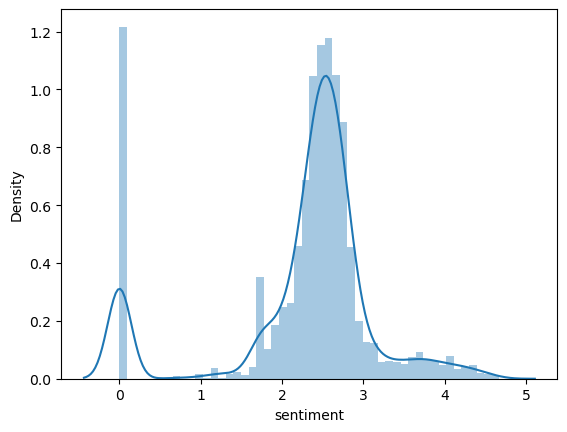

In [31]:
sns.distplot(df['sentiment']) #Histogram on sentiment values

# Several graphs

Most selling countries to England among big leagues by year 

<AxesSubplot:xlabel='season'>

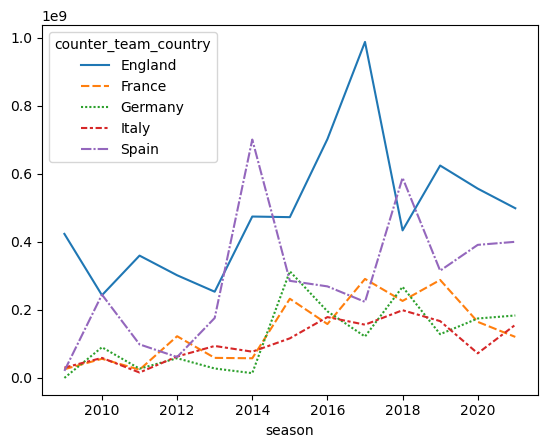

In [72]:
Big_five=['England','Italy','Spain','Germany','France']
df_fee_europe=df[df['dir']=='in']
df_fee_europe=df_fee_europe[df_fee_europe['counter_team_country'].isin(Big_five)]
fee_graph2=df_fee_europe.groupby(by=['season','counter_team_country']).sum()['transfer_fee_amnt']
sns.lineplot(data=fee_graph2.unstack())

Most buying countries from England among big leagues by year 

<AxesSubplot:xlabel='season'>

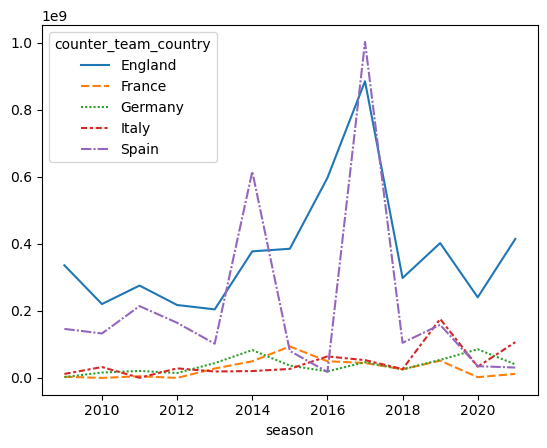

In [73]:
df_fee_europe=df[df['dir']=='left']
df_fee_europe=df_fee_europe[df_fee_europe['counter_team_country'].isin(Big_five)]
fee_graph2=df_fee_europe.groupby(by=['season','counter_team_country']).sum()['transfer_fee_amnt']
sns.lineplot(data=fee_graph2.unstack())

Most selling continent to England among rest of the world by year 

<AxesSubplot:xlabel='season'>

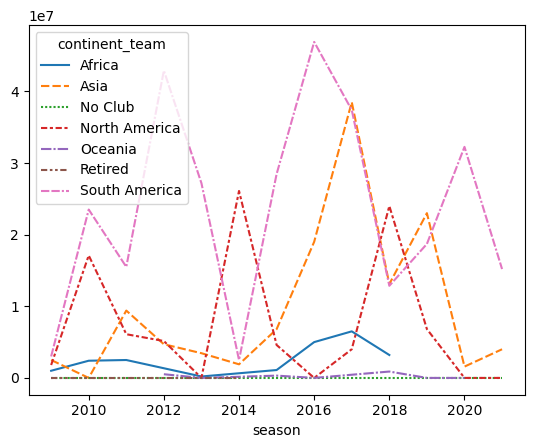

In [74]:
import seaborn as sns
df_fee=df[df['dir']=='in']
df_fee=df_fee.groupby(by=['season','continent_team']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack().drop(['Europe','England','Ban'],axis=1))

Most buying continents from England among rest of the world by year 

<AxesSubplot:xlabel='season'>

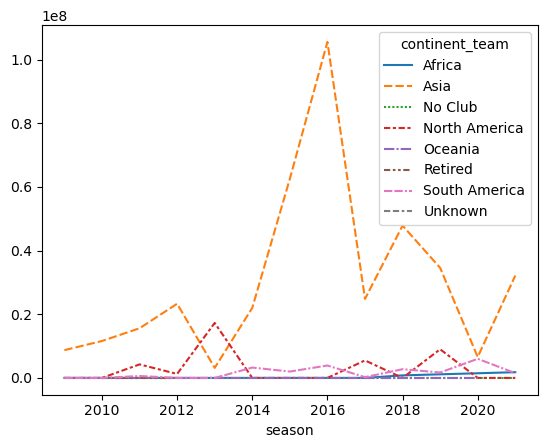

In [75]:
import seaborn as sns
df_fee=df[df['dir']=='left']
df_fee=df_fee.groupby(by=['season','continent_team']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack().drop(['Europe','England'],axis=1))

Difference between in and out players fee by year

<AxesSubplot:xlabel='season'>

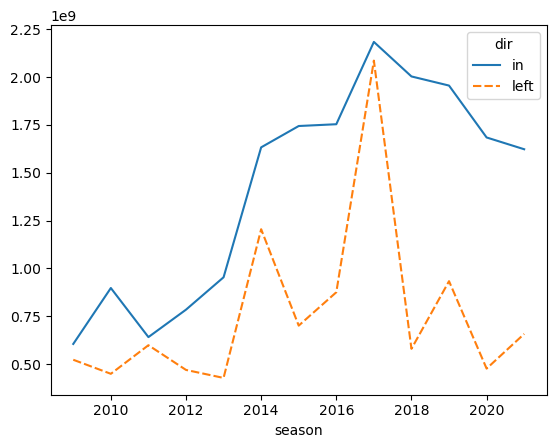

In [76]:
df_fee=df.groupby(by=['season','dir']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack())

Sum of fees by player age

<AxesSubplot:xlabel='player_age'>

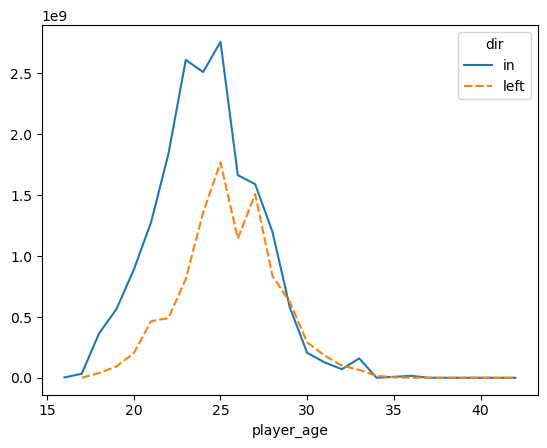

In [77]:
df_fee=df.groupby(by=['player_age','dir']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack())

# Network code

In [32]:
G = nx.MultiDiGraph()
for index, row in df.iterrows():
    if row['team_country'] == 'England' or row['counter_team_country'] == 'England':
        if row['team_name'] not in G.nodes():
            G.add_node(row['team_name'], league=row['team_country'],continent='England')
        if row['counter_team_name'] not in G.nodes():
            G.add_node(row['counter_team_name'], league=row['counter_team_country'],continent=row['continent_team'])
for index, row in df.iterrows():
    if row['team_country'] == 'England' or row['counter_team_country'] == 'England':
        if math.isnan(row['transfer_fee_amnt']):
            tmpfee = 0
        else:
            tmpfee = row['transfer_fee_amnt']
        if row['dir'] == 'in':
            G.add_edge(row['counter_team_name'],row['team_name'], player = row['player_name'], fee = tmpfee,nationality=row['player_nation'],continent_player=row['continent_player'])
        else:
            G.add_edge(row['team_name'],row['counter_team_name'], player = row['player_name'], fee = tmpfee,nationality=row['player_nation'],continent_player=row['continent_player'])

In [6]:
tmpset = set(nx.get_node_attributes(G, 'league').values())

In [7]:
inthash = dict()
counter = 1
for i in tmpset:
    inthash[i] = counter
    counter+=1

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 27.93it/s]


BarnesHut Approximation  took  5.87  seconds
Repulsion forces  took  63.50  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.78  seconds


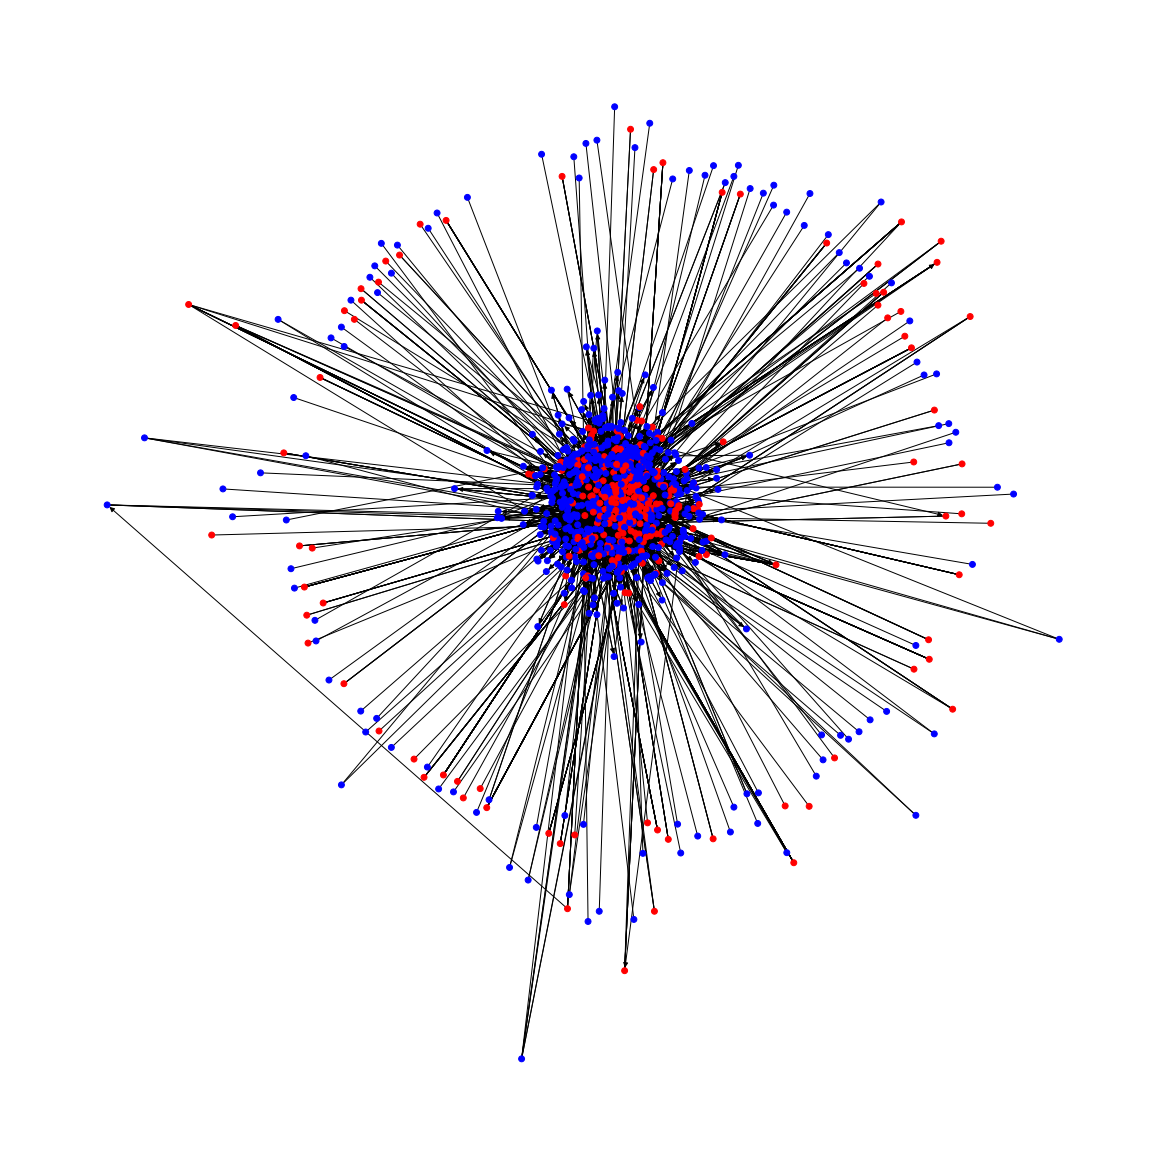

In [8]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=0.1,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
#colors = [inthash[nx.get_node_attributes(G, 'league')[i]]/len(tmpset) for i in G.nodes()]
colors = ['red' if nx.get_node_attributes(G, 'league')[i] == 'England' else 'blue' for i in G.nodes()]
plt.figure(figsize=(16,16)) 
#plt.axis([-1500, 1500, -1500, 1500])
nx.draw(G, pos=positions, node_color=colors, edge_color='black', arrows=True, arrowsize=10, node_size=35)
#txt="Our graph plotted with forceatlas, colours being worlds red=marvel, blue=dc and nodesize being based on node degree"
#plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

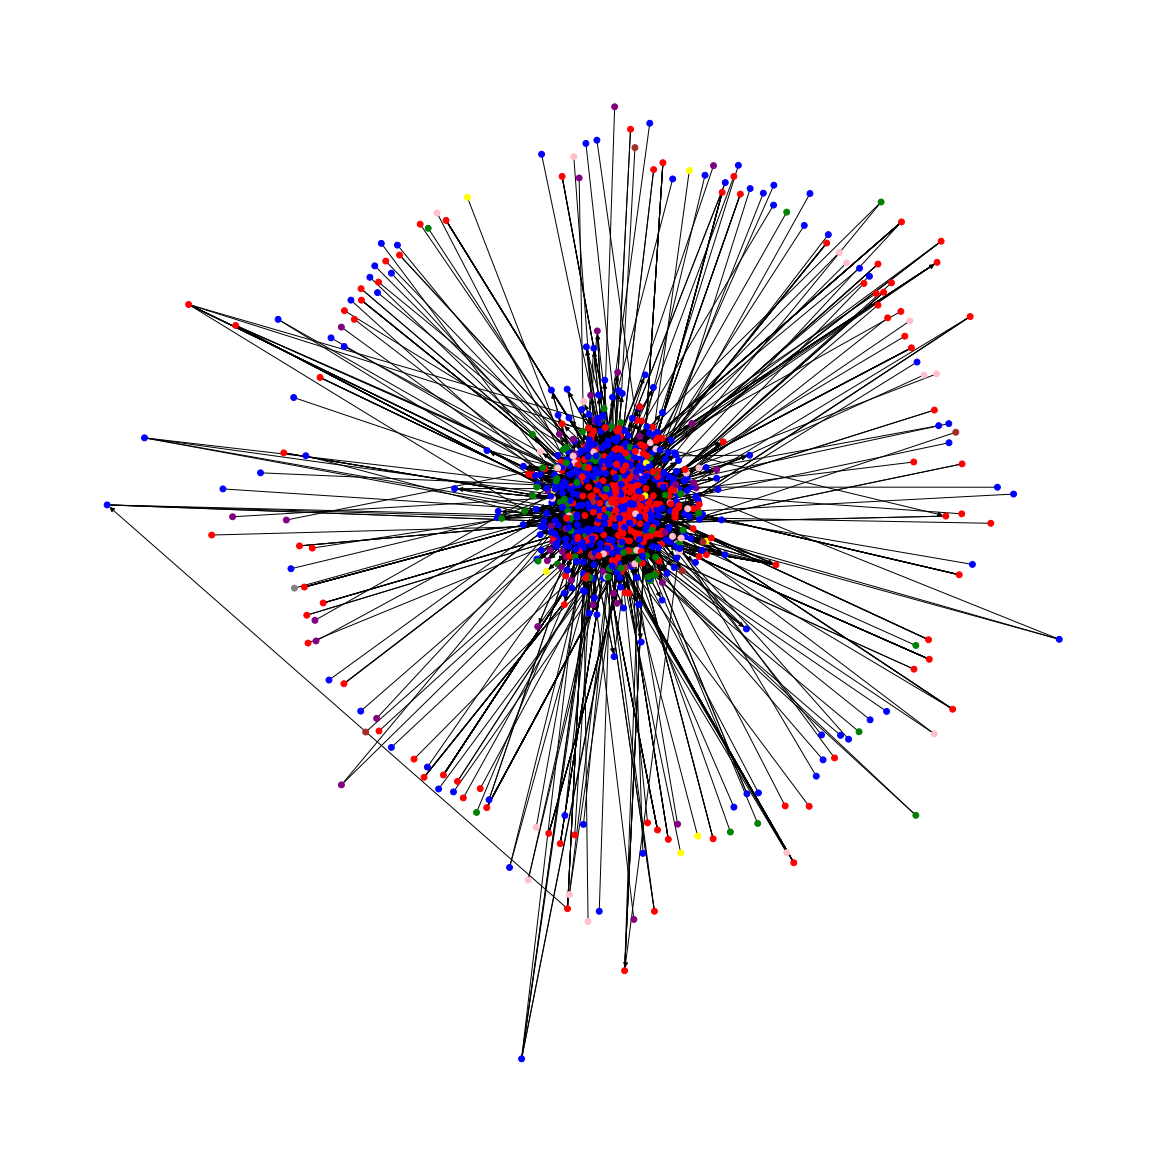

In [25]:
color_map = nx.get_node_attributes(G,'continent')
for key in color_map:
    if color_map[key] == 'England':
        color_map[key] = 'red'
    elif color_map[key] == 'Europe':
        color_map[key] = 'blue'
    elif color_map[key] == 'Africa':
        color_map[key] = 'yellow'
    elif color_map[key] == 'Asia':
        color_map[key] = 'green'
    elif color_map[key] == 'North America':
        color_map[key] = 'pink'
    elif color_map[key] == 'Oceania':
        color_map[key] = 'brown'
    elif color_map[key] == 'South America':
        color_map[key] = 'purple'
    else:
        color_map[key] = 'gray'
contcolor = [color_map.get(node) for node in G.nodes()]
plt.figure(figsize=(16,16)) 
nx.draw(G, pos=positions, node_color=contcolor, edge_color='black', arrows=True, arrowsize=10, node_size=35)

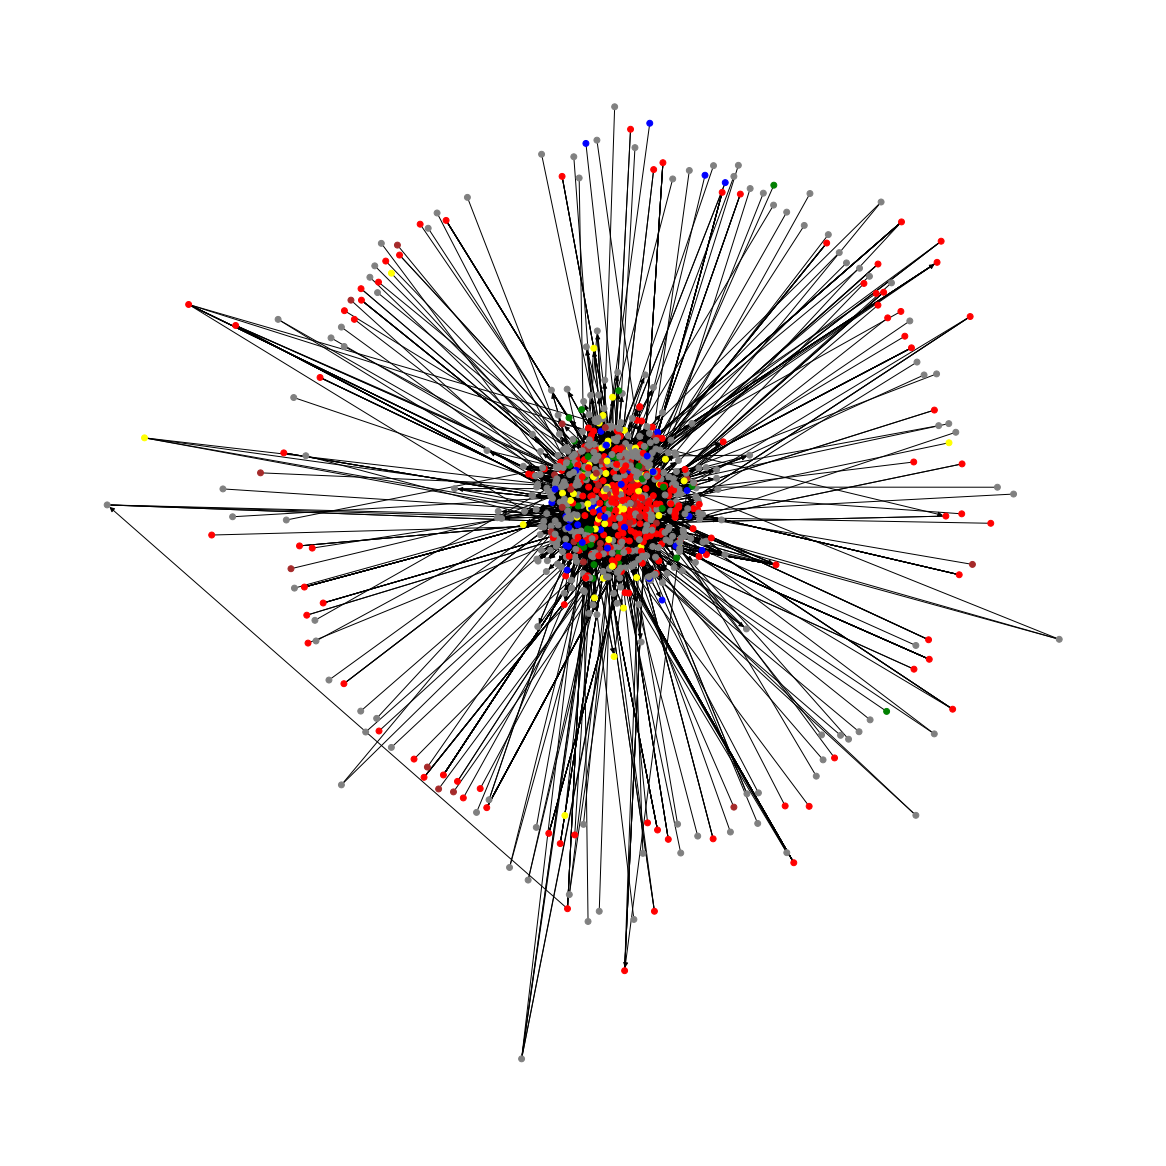

In [26]:
colors = ['red' if nx.get_node_attributes(G, 'league')[i] == 'England' else 'yellow' if nx.get_node_attributes(G, 'league')[i] == 'Spain'
          else 'blue' if nx.get_node_attributes(G, 'league')[i] == 'Italy' else 'green' if nx.get_node_attributes(G, 'league')[i] == 'Germany' 
          else 'brown' if nx.get_node_attributes(G, 'league')[i] == 'France' else 'gray' for i in G.nodes()]
plt.figure(figsize=(16,16)) 
#plt.axis([-1500, 1500, -1500, 1500])
nx.draw(G, pos=positions, node_color=colors, edge_color='black', arrows=True, arrowsize=10, node_size=35)

C:\Users\Paulo\AppData\Local\Temp\ipykernel_1476\505516622.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


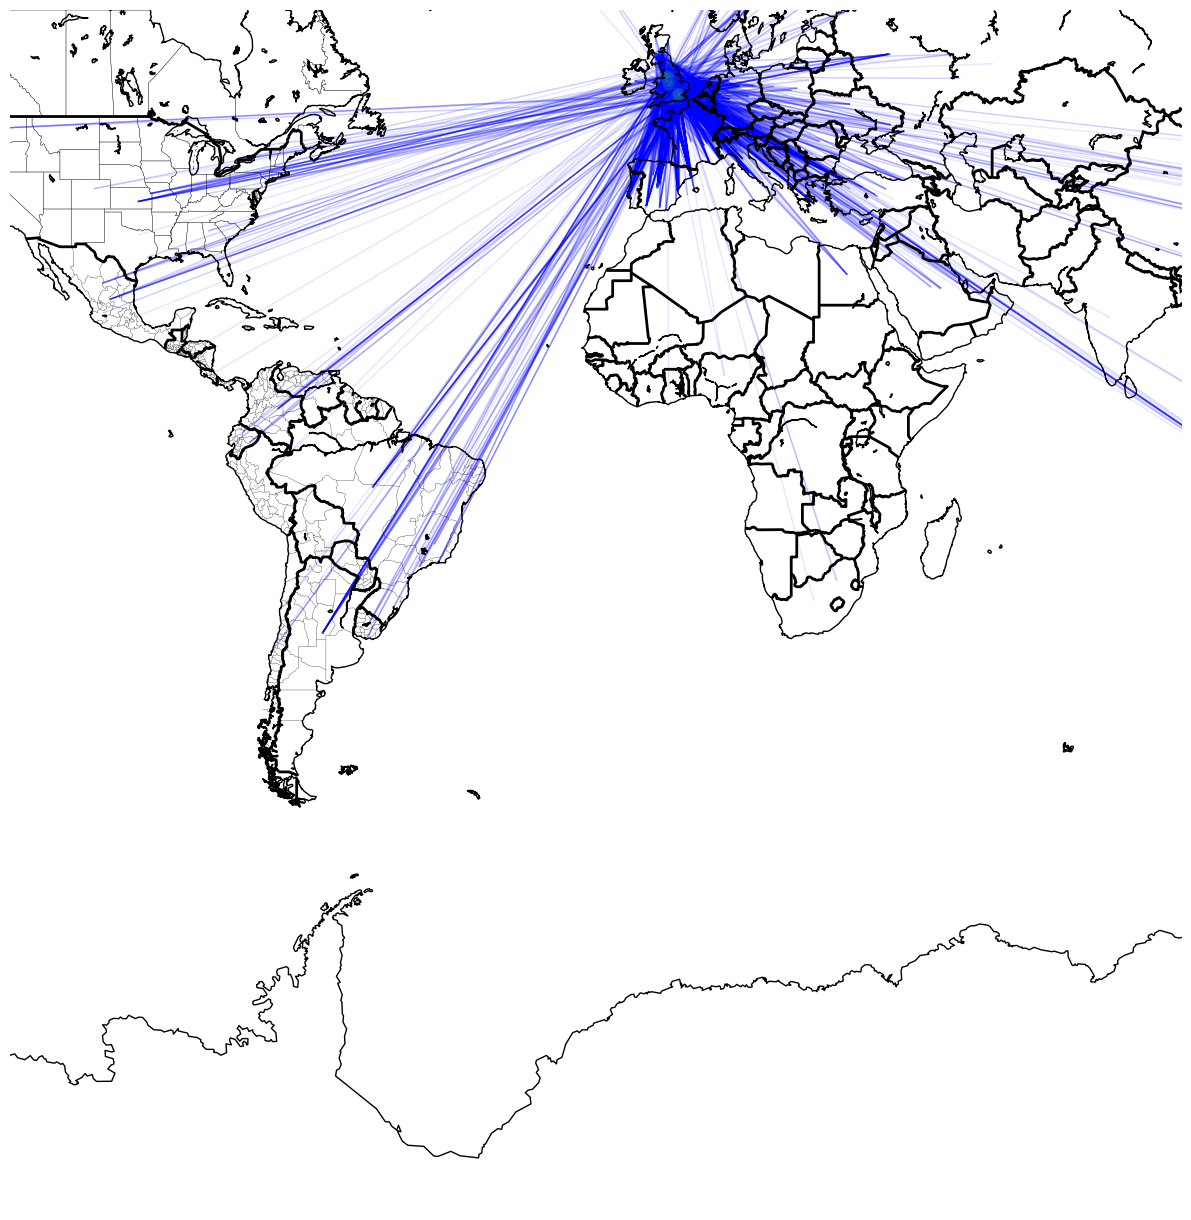

In [33]:
#df.dropna(subset=['Longitude_counter_team','Latitude_counter_team'],inplace=True)

plt.figure(figsize = (14,12))
m = Basemap(projection='merc',llcrnrlon=-120,llcrnrlat=-80,urcrnrlon=90, 
urcrnrlat=60, lat_ts=0, resolution='l',suppress_ticks=True)

mx, my = m(df['Longitude_counter_team'].values,df['Latitude_counter_team'].values)
pos = {}
for count, elem in enumerate (df['counter_team_name']):
    pos[elem] = (mx[count], my[count])
    
d = dict(G.degree)
#nx.draw_networkx_edges(G, pos = pos, edge_color='blue', alpha=0.1, arrows = False,node_size=[v * 100 for v in d.values()])
nx.draw(G, pos = pos, edge_color='blue', alpha=0.1, arrows = False,node_size=[v * 0.1 for v in d.values()])
m.drawcountries(linewidth = 2)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
plt.tight_layout()
plt.savefig("map.png", dpi = 300)
plt.show()

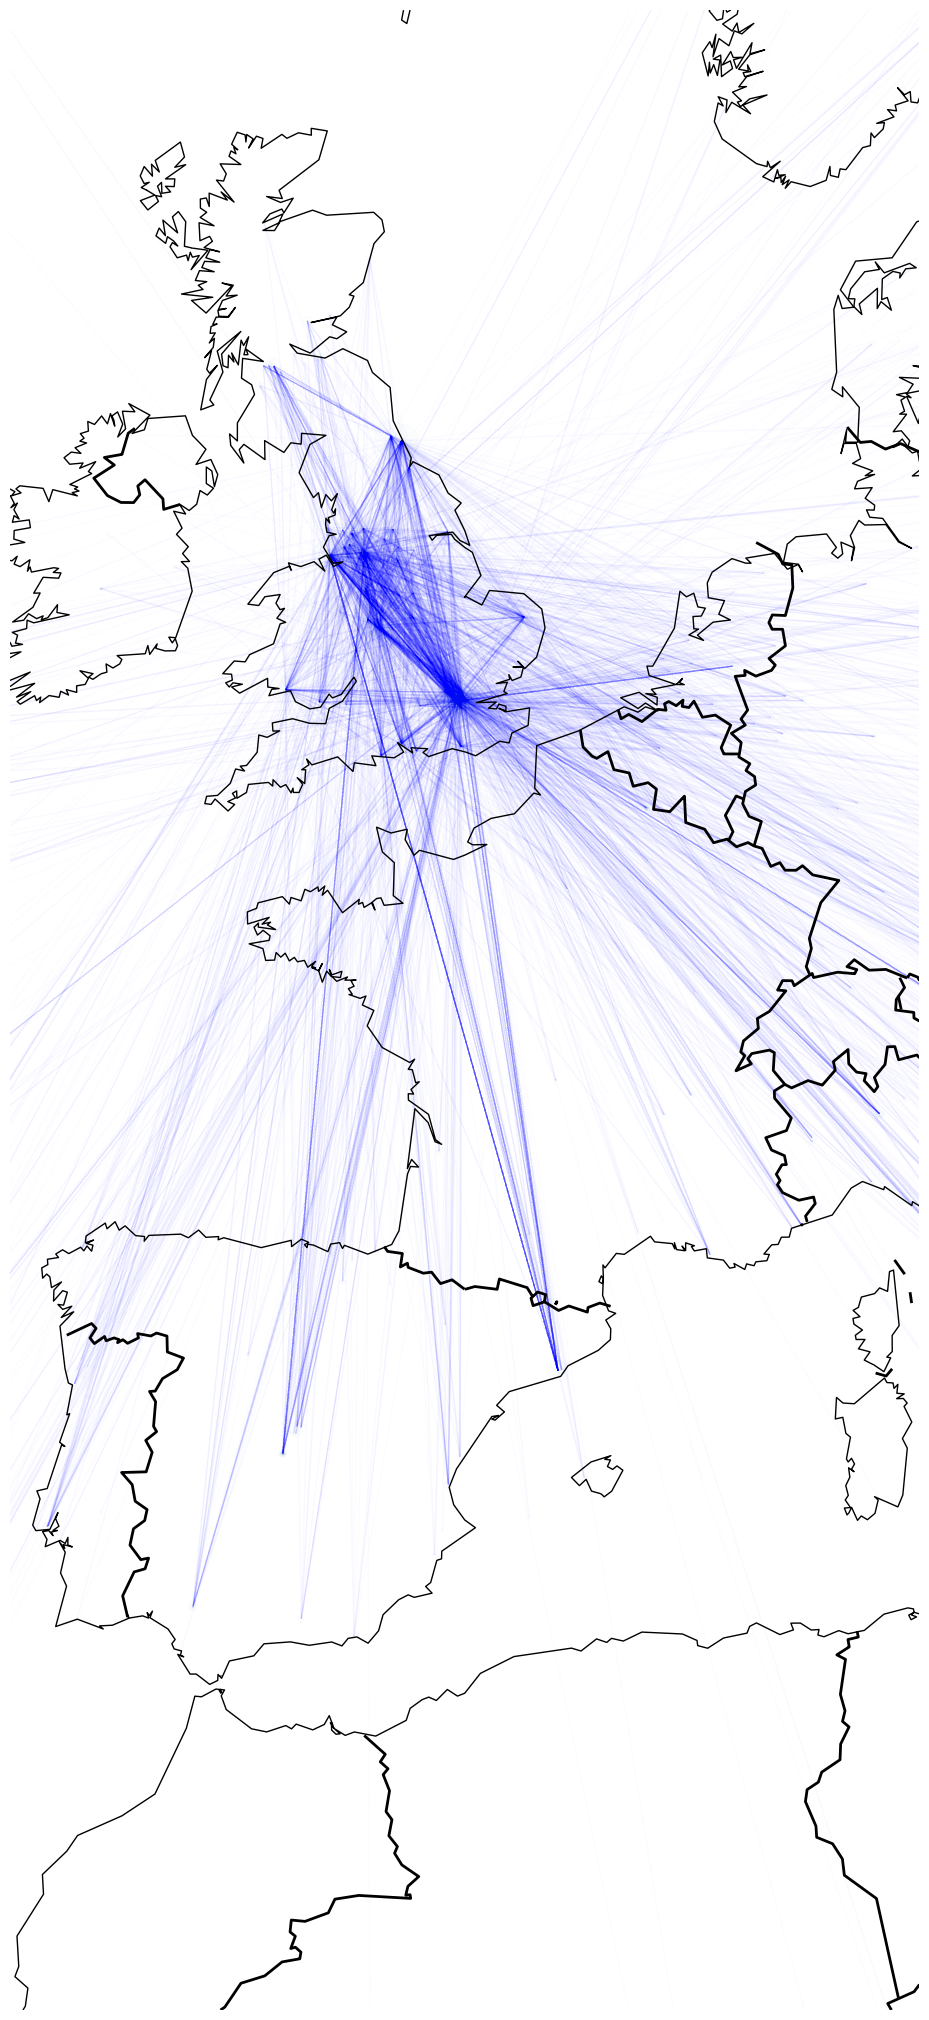

In [36]:
#df.dropna(subset=['Longitude_counter_team','Latitude_counter_team'],inplace=True)

plt.figure(figsize = (10,20))
m = Basemap(projection='merc',llcrnrlon=-10,llcrnrlat=30,urcrnrlon=10, 
urcrnrlat=60, lat_ts=0, resolution='l',suppress_ticks=True)

mx, my = m(df['Longitude_counter_team'].values,df['Latitude_counter_team'].values)
pos = {}
for count, elem in enumerate (df['counter_team_name']):
    pos[elem] = (mx[count], my[count])
    
d = dict(G.degree)
#nx.draw_networkx_edges(G, pos = pos, edge_color='blue', alpha=0.1, arrows = False,node_size=[v * 100 for v in d.values()])
nx.draw(G, pos = pos, edge_color='blue', alpha=0.01, arrows = False,node_size=[v * 1 for v in d.values()])
m.drawcountries(linewidth = 2)
m.drawstates(linewidth = 0.9)
m.drawcoastlines(linewidth=1)
#plt.tight_layout()
plt.savefig("map_England.png", dpi = 300)
plt.show()


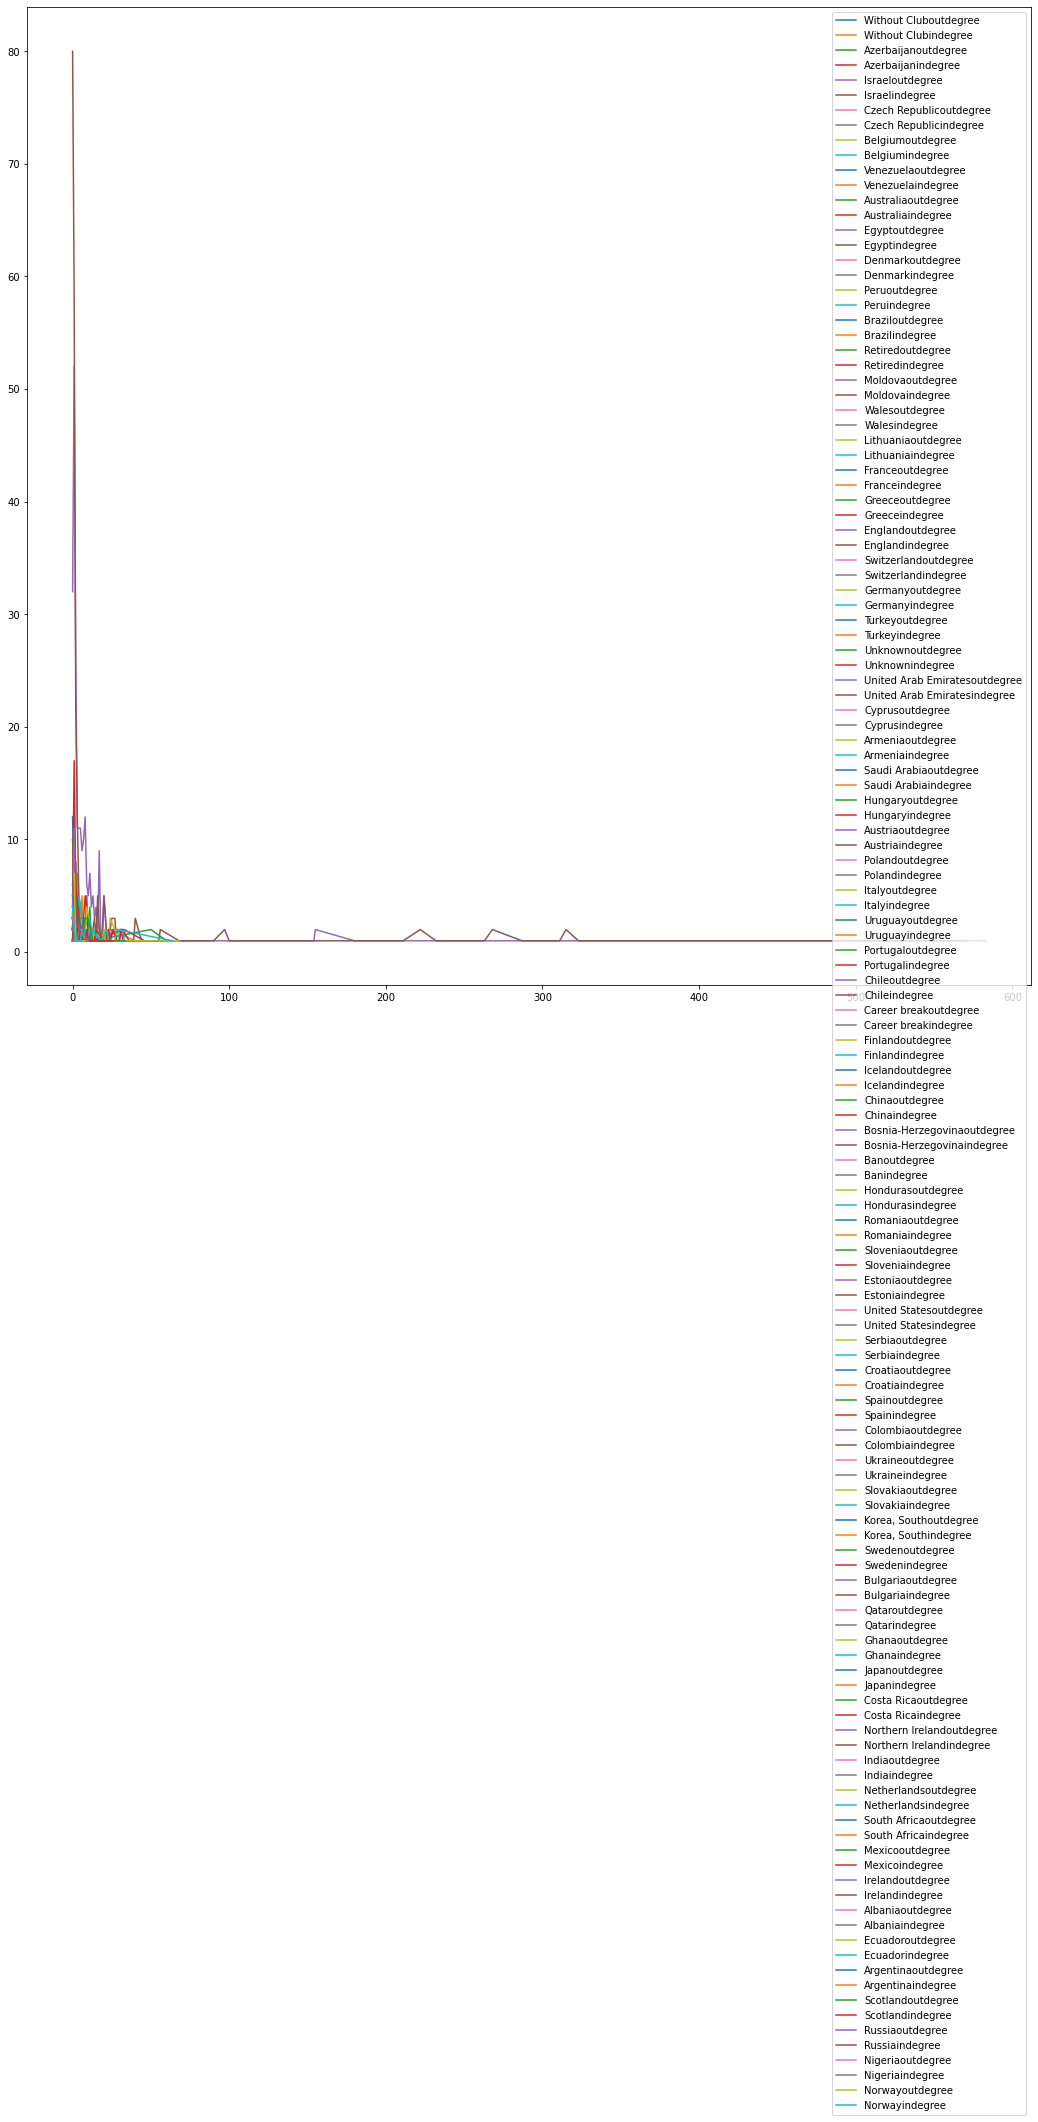

In [10]:
#nx.get_node_attributes(G, 'league')
fig = plt.figure("Degree of a random graph", figsize=(18, 18))
for i in tmpset:
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    outdegree_sequence = sorted((d for n, d in G.out_degree() if n in tmpnodes), reverse=True)
    indegree_sequence = sorted((d for n, d in G.in_degree() if n in tmpnodes), reverse=True)
    plt.plot(*np.unique(outdegree_sequence, return_counts=True), label=i+'outdegree')
    plt.plot(*np.unique(indegree_sequence, return_counts=True), label=i+'indegree')
plt.legend()
plt.show()

In [11]:
transferstocountry = dict()
transfersfromcountry = dict()
for i in tmpset:
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    outdegree_sequence = sorted((d for n, d in G.out_degree() if n in tmpnodes), reverse=True)
    transfersfromcountry[i] = sum(outdegree_sequence)
    indegree_sequence = sorted((d for n, d in G.in_degree() if n in tmpnodes), reverse=True)
    transferstocountry[i] = sum(indegree_sequence)

In [12]:
sorted_ttc = sorted(transferstocountry.items(), key=lambda x:x[1], reverse=True)
sorted_tfc = sorted(transfersfromcountry.items(), key=lambda x:x[1], reverse=True)
print('transfers to country')
print(sorted_ttc[1:11])
print('transfers from country')
print(sorted_tfc[1:11])

transfers to country
[('Spain', 632), ('Italy', 415), ('France', 382), ('Netherlands', 365), ('Germany', 357), ('Without Club', 258), ('Portugal', 208), ('Scotland', 163), ('Retired', 103), ('Turkey', 101)]
transfers from country
[('Spain', 650), ('France', 521), ('Italy', 494), ('Netherlands', 423), ('Germany', 410), ('Portugal', 249), ('Scotland', 161), ('Belgium', 91), ('Turkey', 60), ('Without Club', 57)]


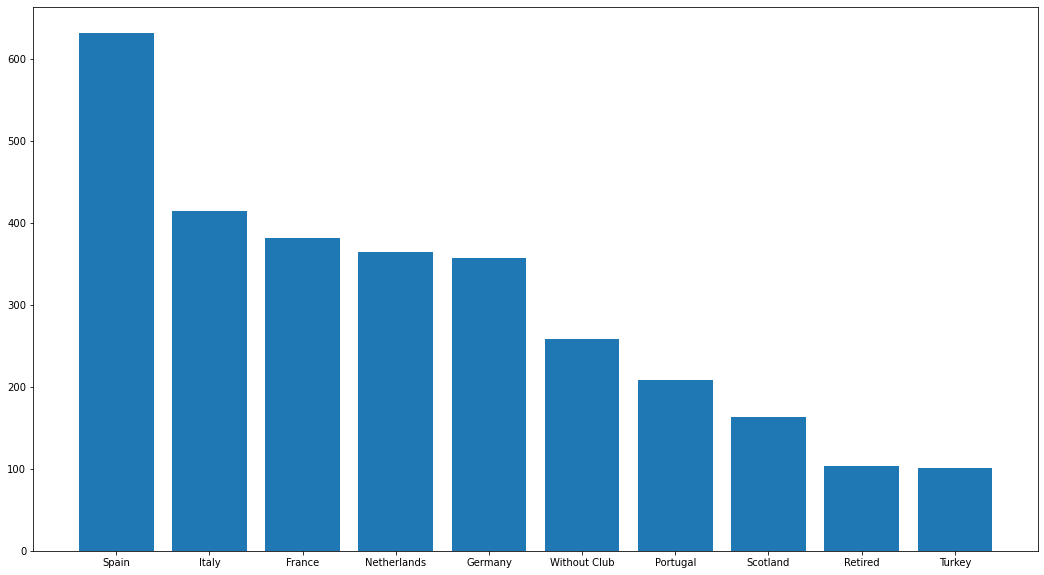

In [13]:
x = []
y = []
for i in sorted_ttc[1:11]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries buying players from the premier league", figsize=(18, 10))
plt.bar(x,y)
plt.show()

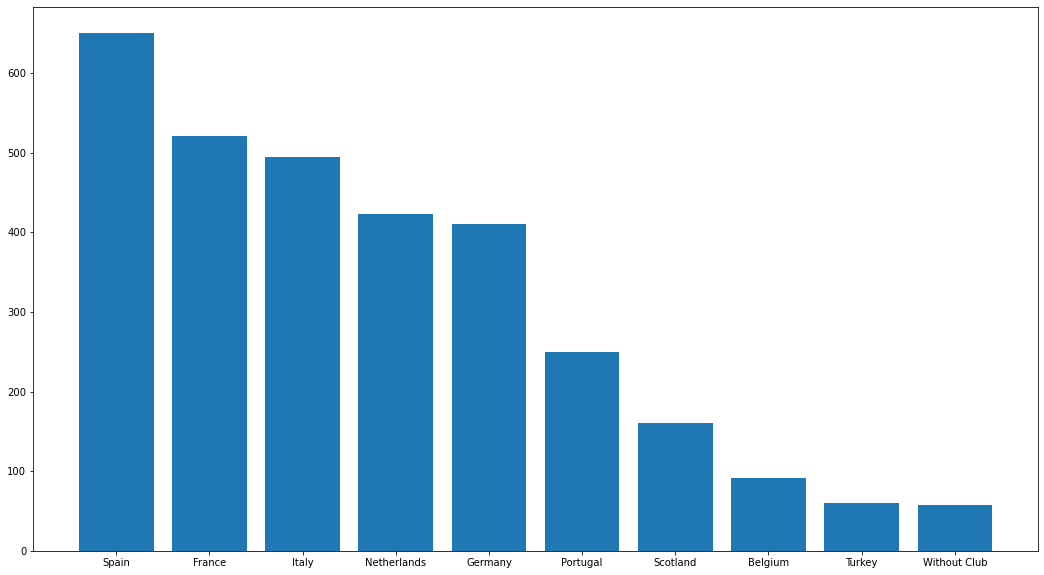

In [14]:
x = []
y = []
for i in sorted_tfc[1:11]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries selling players to the premier league", figsize=(18, 10))
plt.bar(x,y)
plt.show()

In [15]:
nx.get_edge_attributes(G, 'fee')
transferfeetocountry = dict()
transferfeefromcountry = dict()
for i in tmpset:
    if i == 'England':
        continue
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    tmpfrom = [z['fee'] for f, t, z in G.edges(data=True) if f in tmpnodes]
    transferfeefromcountry[i] = sum(tmpfrom)
    tmpto = [z['fee'] for f, t, z in G.edges(data=True) if t in tmpnodes]
    transferfeetocountry[i] = sum(tmpto)

In [16]:
counter = 0
for x,y,z in G.edges(data=True):
    counter+=1

In [17]:
sorted_tftc = sorted(transferfeetocountry.items(), key=lambda x:x[1], reverse=True)
sorted_tffc = sorted(transferfeefromcountry.items(), key=lambda x:x[1], reverse=True)
print('transfers to country')
print(sorted_tftc[1:11])
print('transfers from country')
print(sorted_tffc[1:11])

transfers to country
[('Italy', 1283522000.0), ('Germany', 921640000.0), ('France', 815130000.0), ('China', 193890000.0), ('Netherlands', 149740000.0), ('Russia', 128700000.0), ('Turkey', 117121000.0), ('Portugal', 105580000.0), ('Qatar', 36000000.0), ('Scotland', 35640000.0)]
transfers from country
[('France', 3712295000.0), ('Germany', 2896300000.0), ('Italy', 2804400000.0), ('Portugal', 1619828000.0), ('Netherlands', 1285775000.0), ('Belgium', 337510000.0), ('Russia', 205690000.0), ('Brazil', 195380000.0), ('Scotland', 171280000.0), ('Ukraine', 127715000.0)]


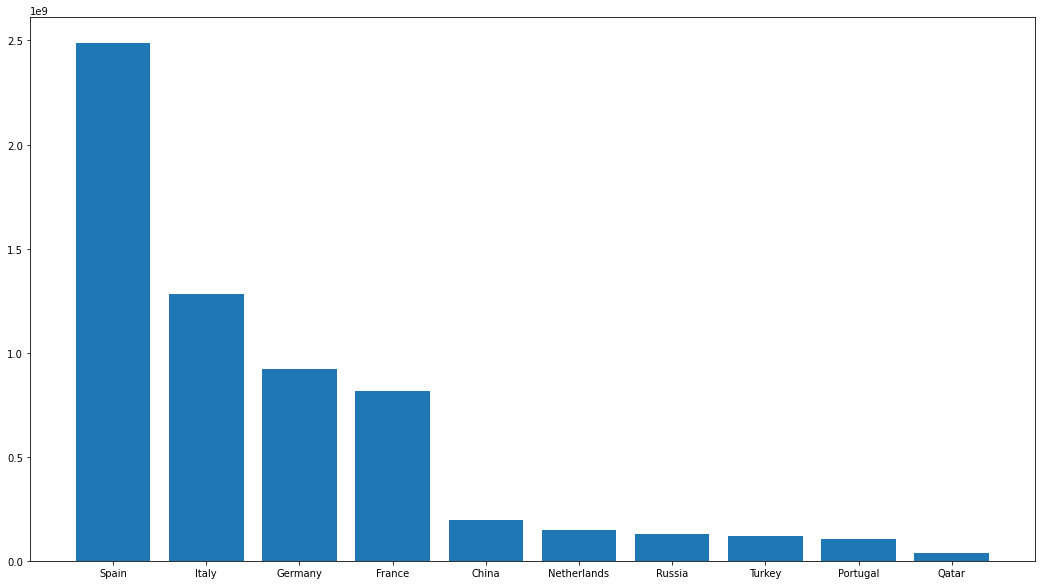

In [18]:
x = []
y = []
for i in sorted_tftc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries buying players from the premier league, fee", figsize=(18, 10))
plt.bar(x,y)
plt.show()

In [19]:
print(transferfeefromcountry['Spain'])
print(transferfeefromcountry['Italy'])

4170615000.0
2804400000.0


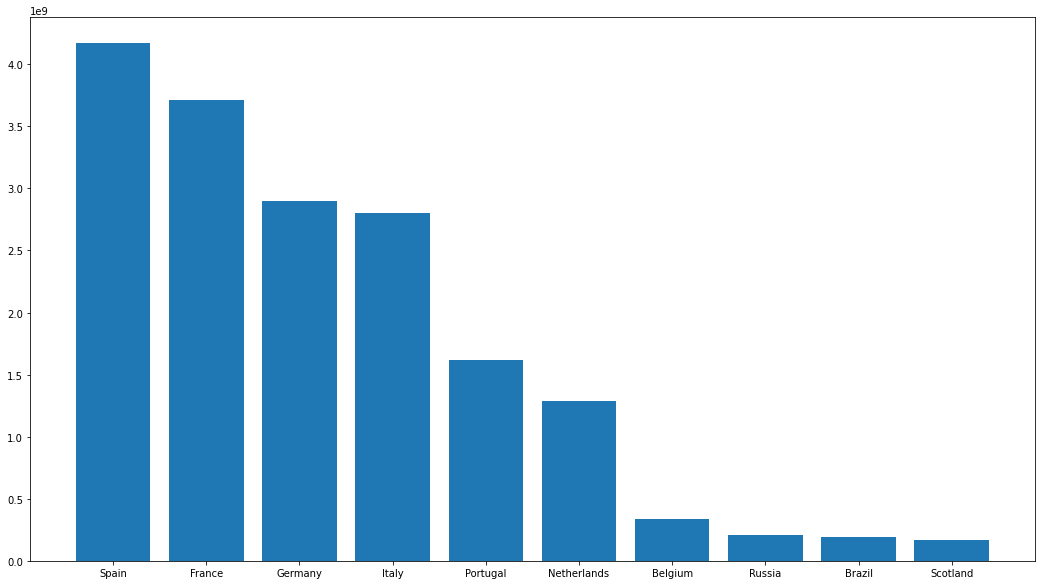

In [20]:
x = []
y = []
for i in sorted_tffc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries selling players to the premier league, fee", figsize=(18, 10))
plt.bar(x,y)
plt.show()